In [3]:
!pip install matplotlib

In [4]:
import cv2, os

from keras.models import Model
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy


In [5]:
data_path="/kaggle/input/genderclassifier/Train"

In [6]:
data_path

'/kaggle/input/genderclassifier/Train'

In [7]:
types=os.listdir(data_path)
labels = [i for i in range(len(types))]
label_dict = dict(zip(types, labels))
print(label_dict)
print(types)
print(labels)

{'Female': 0, 'Male': 1}
['Female', 'Male']
[0, 1]


In [8]:
image_sizes = 224
dataset = []
target = []


for typ in types:
    folder_path = os.path.join(data_path , typ)
    images_names = os.listdir(folder_path)
    
    
    
    #loop inside each folder
    for img_name in images_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        
        
        
        try:
            #convert image into gray scale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, (image_sizes, image_sizes))
            dataset.append(resized_img)
            target.append(label_dict[typ])
            
        #if any exception arises    
        except Exception as e:
            prin("Exception:", e)

In [9]:
import numpy as np
dataset = np.array(dataset)/255.0
dataset= np.reshape(dataset, (dataset.shape[0], image_sizes, image_sizes, 1))
target = np.array(target)

In [10]:

from keras.utils import np_utils
new_target = np_utils.to_categorical(target)

In [11]:
with open('dataset.npy', 'wb') as f:
    np.save(f, dataset)
with open('target.npy', 'wb') as g:
    np.save(g,new_target)

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau 

In [25]:
dataset.shape[1:]

(224, 224, 1)

In [26]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=dataset.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(1,activation='softmax'))
#The Final layer with two outputs for two categories

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 200)     2000      
_________________________________________________________________
activation_2 (Activation)    (None, 222, 222, 200)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 200)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 100)     180100    
_________________________________________________________________
activation_3 (Activation)    (None, 109, 109, 100)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 291600)           

In [28]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(dataset,target,test_size=0.1)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

In [30]:
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

In [31]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [32]:
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [33]:
history=model.fit(train_data,train_target,epochs=40,callbacks=[callbacks_list],validation_split=0.2)

Epoch 1/40
113/113 [==============================] - 876s 8s/step - loss: 0.0000e+00 - accuracy: 0.3924 - val_loss: 0.0000e+00 - val_accuracy: 0.4311
Epoch 2/40
113/113 [==============================] - 861s 8s/step - loss: 0.0000e+00 - accuracy: 0.4081 - val_loss: 0.0000e+00 - val_accuracy: 0.4311
Epoch 3/40
113/113 [==============================] - 862s 8s/step - loss: 0.0000e+00 - accuracy: 0.3973 - val_loss: 0.0000e+00 - val_accuracy: 0.4311
Epoch 4/40
113/113 [==============================] - 867s 8s/step - loss: 0.0000e+00 - accuracy: 0.3853 - val_loss: 0.0000e+00 - val_accuracy: 0.4311
Restoring model weights from the end of the best epoch.

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 00004: early stopping


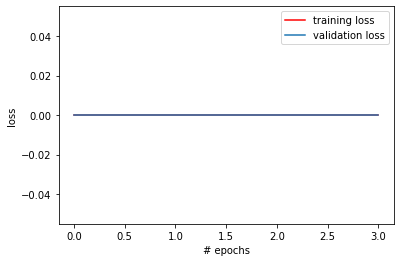

In [34]:

from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

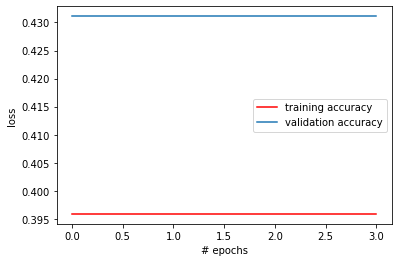

In [35]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()